<h1 align="center">AllLIFE BANK CUSTOMER SEGMENTATION</h1> 

### Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

### Data Dictionary

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import SilhouetteVisualizer

from scipy.stats import zscore
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

In [2]:
# importing or data and viewing it
df=pd.read_excel('Credit+Card+Customer Data.xlsx')
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


### Describing the Data

In [3]:
# copying our data for easy reference in the future
data=df.copy()

In [4]:
 data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


The columns in our data are all integer types meaning we have no string values in the data

In [5]:
data.shape

(660, 7)

The data has 660 records and 7 columns

In [6]:
data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

There are no null records in the data

In [7]:
data.duplicated().sum()

0

There are no duplicates in the data

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


* Some columns like Avg_Credit_Limit have a high statistical view than others.
* This can be handled when we scale the data.
* There may be some outliers in the Avg_Credit_Limit column. We will need to analyse that in our EDA to be sure

### Data PreProcessing

In [9]:
data.head(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
5,6,58634,20000,3,0,1,8
6,7,48370,100000,5,0,11,2
7,8,37376,15000,3,0,1,1
8,9,82490,5000,2,0,2,2
9,10,44770,3000,4,0,1,7


* We will need to exclude the SI_No column and also the customer key column.
* These columns will not contribute anything to our model.

In [10]:
clust_data=data.iloc[:,2:]
clust_data.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


* We successfully excluded the columns in building our model

### Exploratory Data Analysis

We will do a little analysis on our data to better understand our data and possibly see how many clusters just from our univariate and bivariate analysis before applying our cluster algorithms. Also we will try to understand the relationship between columns 

### Univariate Analysis

In [11]:
clust_data.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

#### Avg_Credit_Limit

<AxesSubplot:xlabel='Avg_Credit_Limit'>

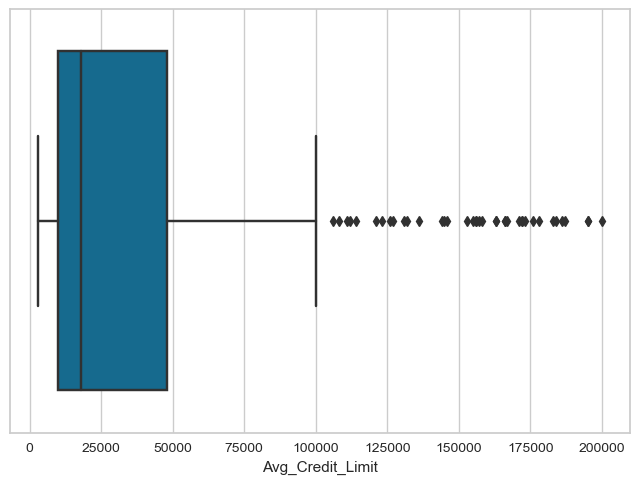

In [12]:
sns.boxplot(data=clust_data,x='Avg_Credit_Limit')

* Majority of the customers have an Average credit card limit between 25000-100,000.
* There are some few outliers and we will have to investigate them

#### Total_Credit_Cards

<AxesSubplot:xlabel='Total_Credit_Cards', ylabel='count'>

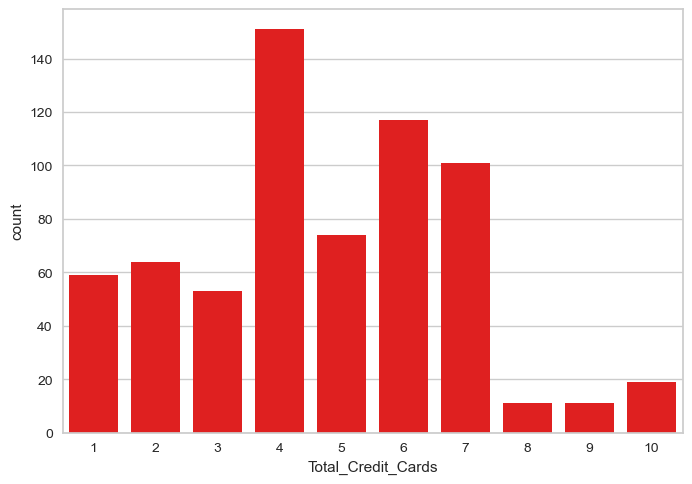

In [13]:
sns.countplot(data=clust_data,x='Total_Credit_Cards',color='red')

In [14]:
clust_data['Total_Credit_Cards'].value_counts()

4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
9      11
8      11
Name: Total_Credit_Cards, dtype: int64

* Most customers have a total of 4 credit cards.
* Also, six credit cards is the second highest amount of credit cards a customer can have.
* Third on the list is customers with 7 an last are customers with 8 cards

#### Total_visits_bank

<AxesSubplot:xlabel='Total_visits_bank', ylabel='count'>

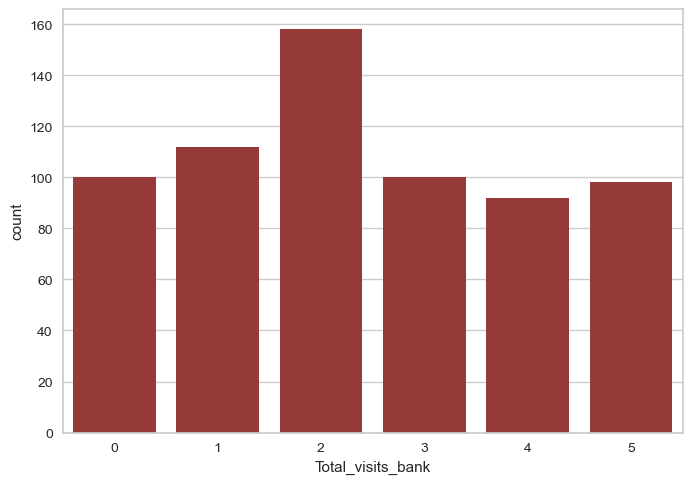

In [15]:
sns.countplot(data=clust_data,x='Total_visits_bank',color='brown')

* Most of the customers visit the bank just twice yearly.
* Second highest number of visits by customers yearly is one

#### Total_visits_online

<AxesSubplot:xlabel='Total_visits_online', ylabel='count'>

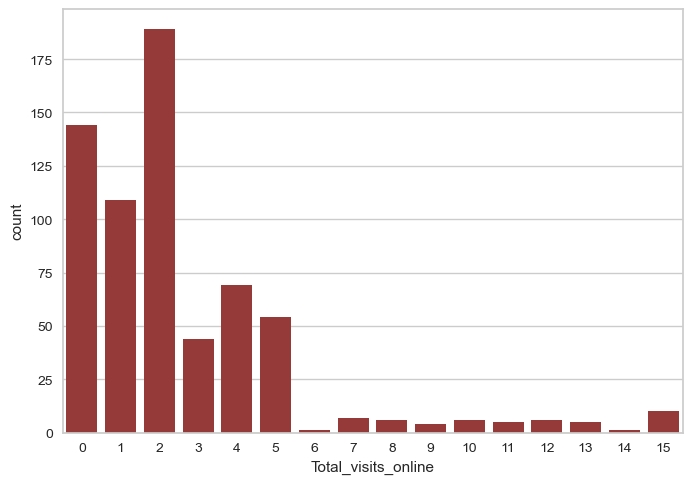

In [16]:
sns.countplot(data=clust_data,x='Total_visits_online',color='brown')

<AxesSubplot:xlabel='Total_visits_online'>

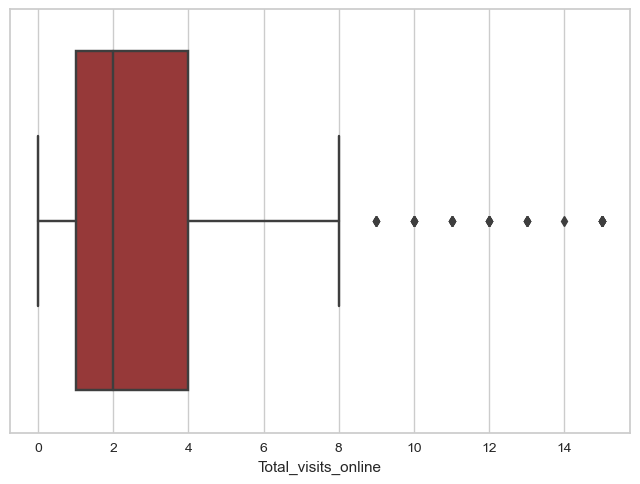

In [17]:
sns.boxplot(data=clust_data,x='Total_visits_online',color='brown')

* From the visualisation for Total visits online, it looks like most customers visit the bank's online pltaform twice every year.
* The number of online visits fall within the range of 1-8 with the rest looking like outliers from the data

#### Total_calls_made

<AxesSubplot:xlabel='Total_calls_made', ylabel='count'>

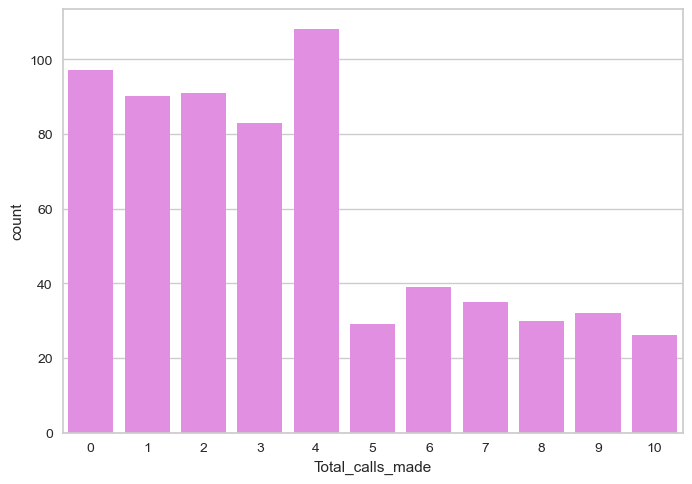

In [18]:
sns.countplot(data=clust_data,x='Total_calls_made',color='violet')

<AxesSubplot:xlabel='Total_calls_made'>

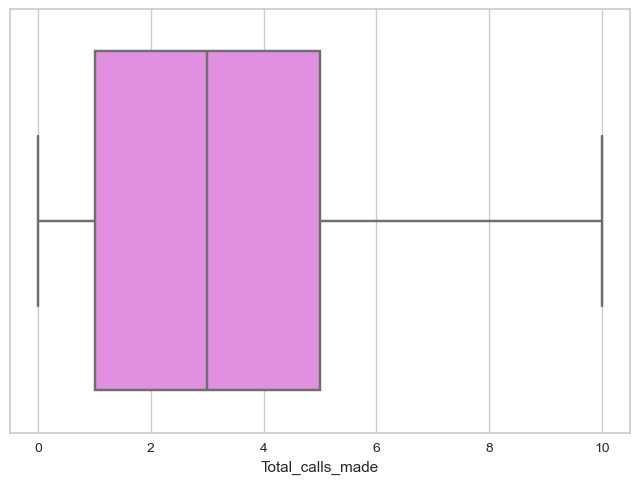

In [19]:
sns.boxplot(data=clust_data,x='Total_calls_made',color='violet')

* Four Calls was the highest amount of calls made by the customers to the bank.
* Also it seems most customers did nit make calls to the bank at all for that year.

### Bivariate and Multivariate Analysis

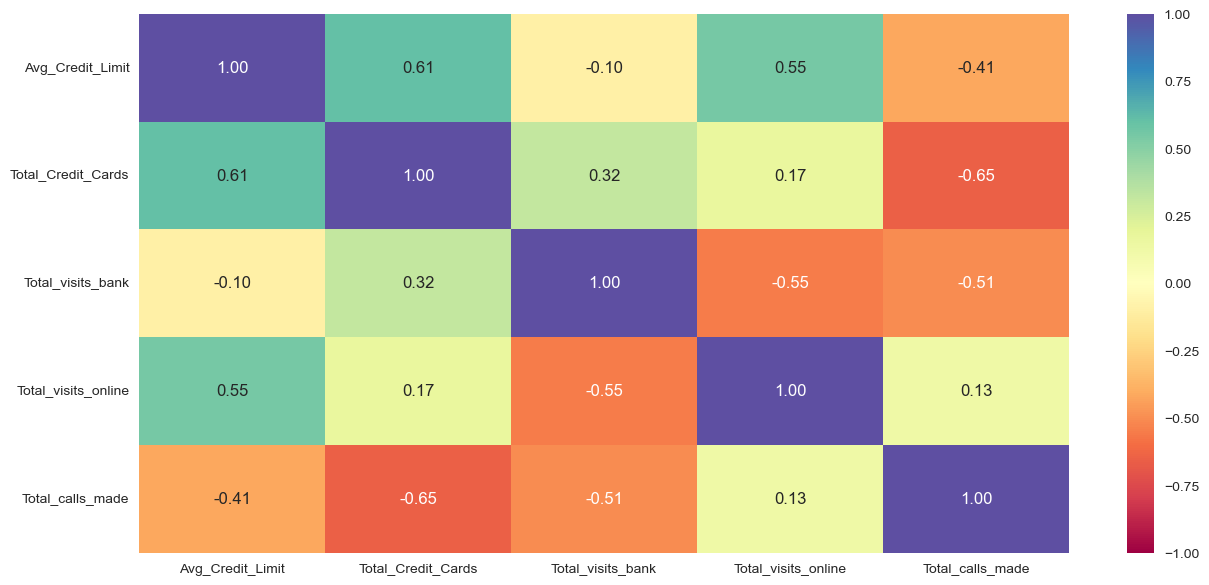

In [20]:
plt.figure(figsize=(15, 7))
sns.heatmap(clust_data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

* Some columns are positively correlated. 
* Avg_Credit_Limit positively correlates with Total_Credit_Crads and Total_Visits_Online. 
* There is a negative correlation between the Avg_Credit_Limit and Total_Calls_made
* Also,Total_calls_made has a high negative correlation with Total_Credit_cards.

In [21]:
clust_data.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


#### Total_Credit_Cards vs Avg_Credit_Limit

<AxesSubplot:xlabel='Total_Credit_Cards', ylabel='Avg_Credit_Limit'>

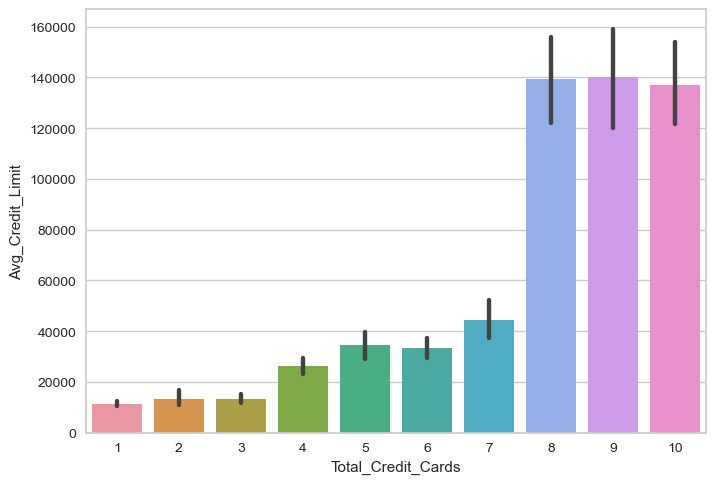

In [22]:
sns.barplot(data=clust_data,x='Total_Credit_Cards',y='Avg_Credit_Limit')

* From our heatmap, we saw that Total Credit cards and Avg Credit Limit have a high positive correlation.
* From the above visualisation, the higher the Total credit cards, the higher the Average Credit Limit

#### Total_visits_online vs Avg_Credit_Limit

<AxesSubplot:xlabel='Total_visits_online', ylabel='Avg_Credit_Limit'>

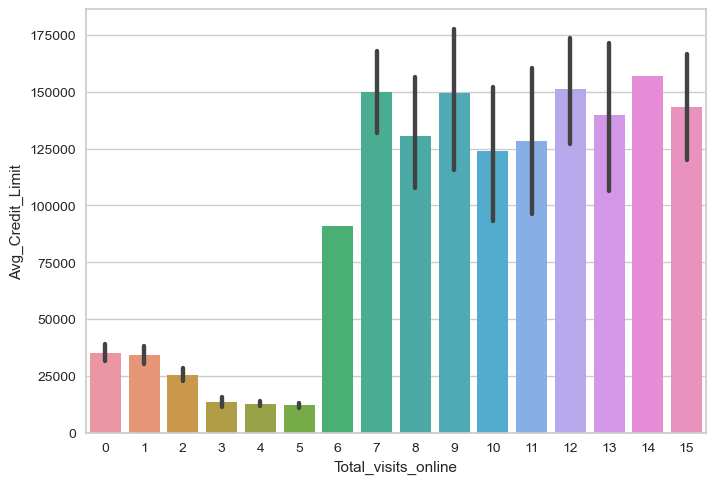

In [23]:
sns.barplot(data=clust_data,x='Total_visits_online',y='Avg_Credit_Limit')

* The relationship between Avg Credit Limit and Total Visits Online is the same as that of Avg Credit Limit and Total Credit Cards.
* The higher the Avg Credit Limit, the higher the number of online visits.

#### Total_visits_bank vs Total_Credit_Cards

<AxesSubplot:xlabel='Total_visits_bank', ylabel='Total_Credit_Cards'>

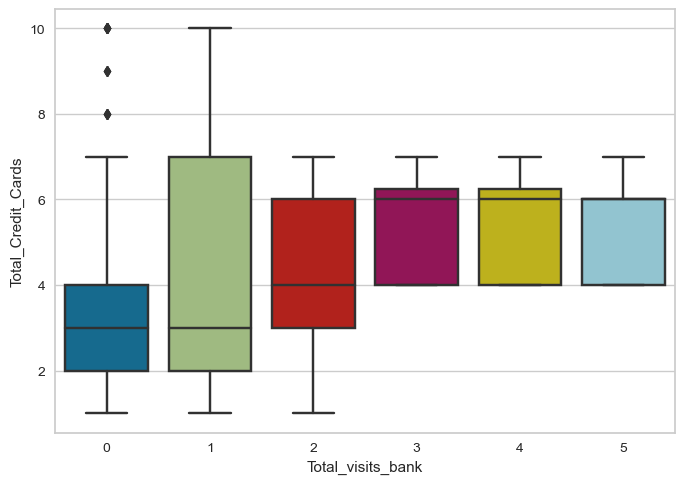

In [24]:
sns.boxplot(data=clust_data,x='Total_visits_bank',y='Total_Credit_Cards')

<AxesSubplot:xlabel='Total_visits_bank', ylabel='Total_Credit_Cards'>

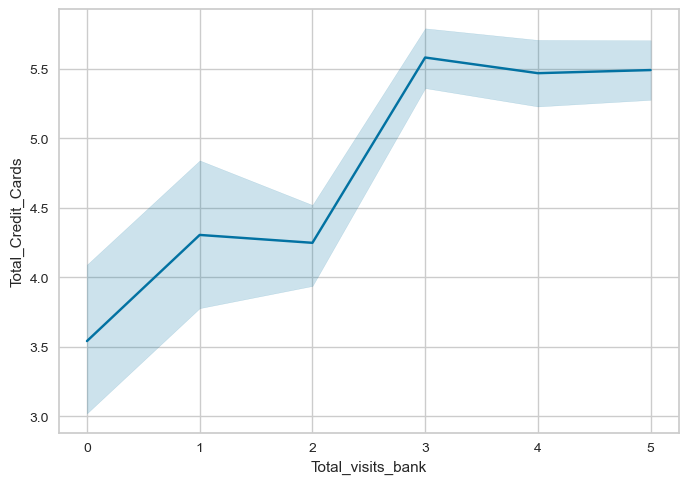

In [25]:
sns.lineplot(data=clust_data,x='Total_visits_bank',y='Total_Credit_Cards')

* The Total Visits Bank and Total Credit Cards is also positively correlated
* The higher the number of Cards, the more likely the customer will visit the bank

### Insights From EDA

* Average Credit limit is a very ig determining factor for the type of customer we may be dealing with
* This is beacuse Average Credit Limit influences some important features in the data
* Also, the number of cards a customer has can give you insights on the type of customer he is.
* The Total Cards and Average Credit Limit are positively related. These are the two most important features from the analysis.
* These two features influence the other features greatly.

### Outlier Detection and Treatment

In [26]:
clust_data.columns

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

In [27]:
cols=['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made']

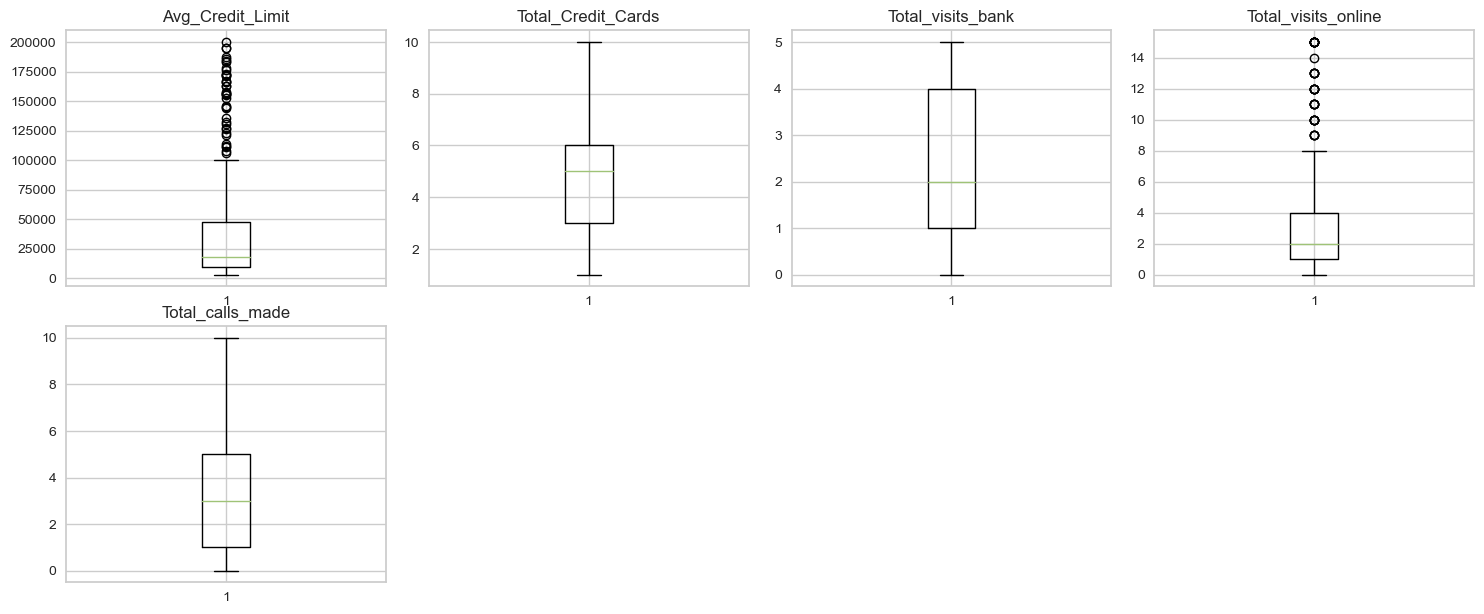

In [28]:
# outlier detection using boxplot
# selecting the numerical columns where outliers were treated 
plt.figure(figsize=(15, 12))

for i, variable in enumerate(cols):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(clust_data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

* From the outlier detection visual, it can be seen that only two columns are giving us outliers
* These two columns are Avg_Credit_Limit and Total_Visits_Online.
* From our EDA we saw that the higher th enumbe rof credit cards, the higher the Average Credit card limit a customer has. So therefore the outliers present in the Avg_Credit_Limit column are useful insights that we can not take out of the data.
* For the Total Visits, we also saw that the Average credit limit directly influences the Total visits online. So therefore, we can choose to keepthose outliers as relevant information

In [29]:
clust_data.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


#### Scaling Data

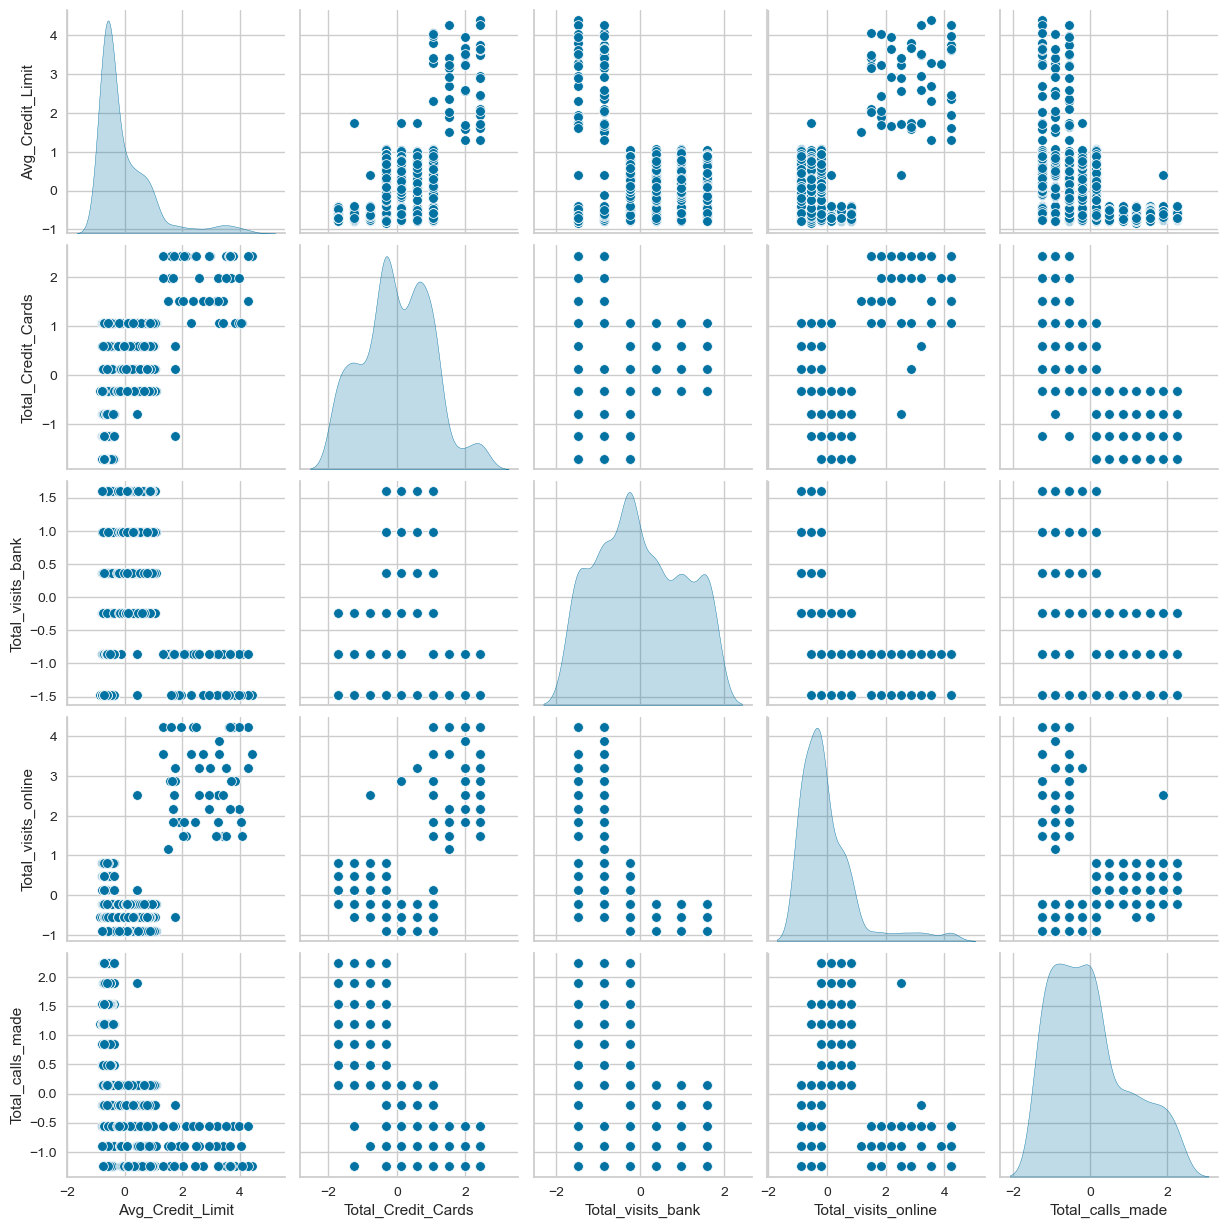

In [30]:
dataScaled=clust_data.apply(zscore)
sns.pairplot(dataScaled,diag_kind='kde')

In [31]:
dataScaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


* From the aove we can see that we successfully scaled the data.

### Applying K-MEANS

Now, we will use K-Means clustering to group data based on their attribute. First, we need to determine the optimal number of groups. For that we conduct the knee test to see where the knee happens.

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

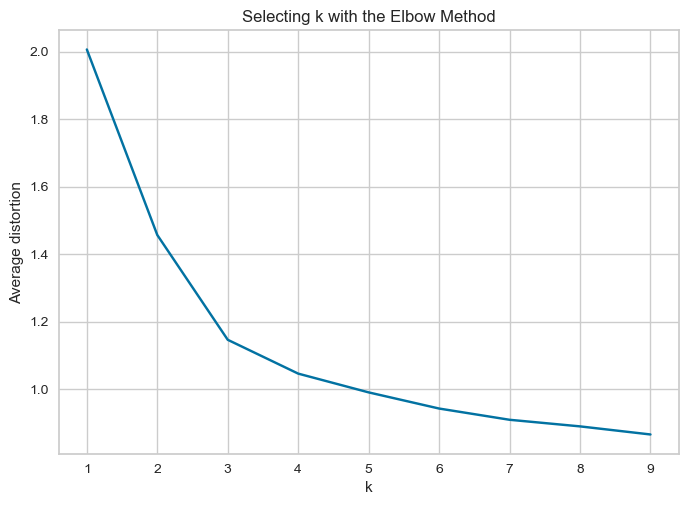

In [32]:
#Finding optimal no. of clusters
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(dataScaled)
    prediction=model.predict(dataScaled)
    meanDistortions.append(sum(np.min(cdist(dataScaled, model.cluster_centers_, 'euclidean'), axis=1)) / dataScaled.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')


* The elbow can be cleary seen around the mark 3. We can try 3 clusters and analyse.

### Silhouette Score Evaluation

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2726698397729061
For n_clusters = 6, silhouette score is 0.25544722696331174
For n_clusters = 7, silhouette score is 0.24827812264147398
For n_clusters = 8, silhouette score is 0.22677509958705028
For n_clusters = 9, silhouette score is 0.21909848894535427


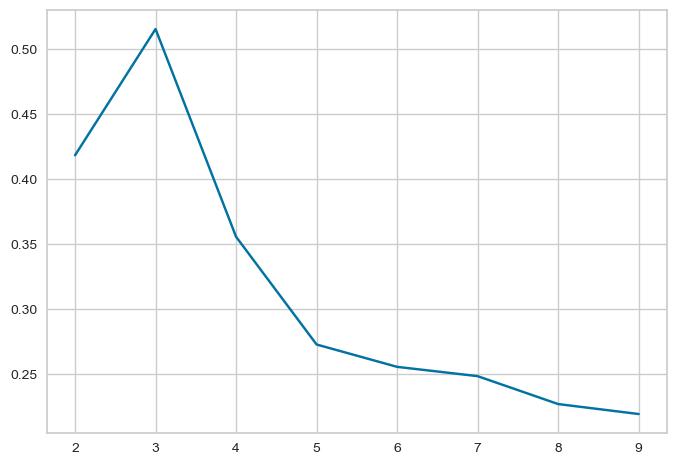

In [33]:
sil_score = []  # Create empty list
cluster_list = list(range(2, 10))  # Creating a list of range from 2 to 10
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)  # Initializing KMeans algorithm
    preds = clusterer.fit_predict((dataScaled))  # Predicting on the data
    # centers = clusterer.cluster_centers_
    score = silhouette_score(dataScaled, preds)  # Cacalculating silhouette score
    sil_score.append(score)  # Appending silhouette score to empty list created above
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

* From the Silhouetter scores, it seems like 3 and 2 are giving good results.
* Lets use the Silhouette visualizer and derive more insights from the clusters.

### Silhouette Visualizer

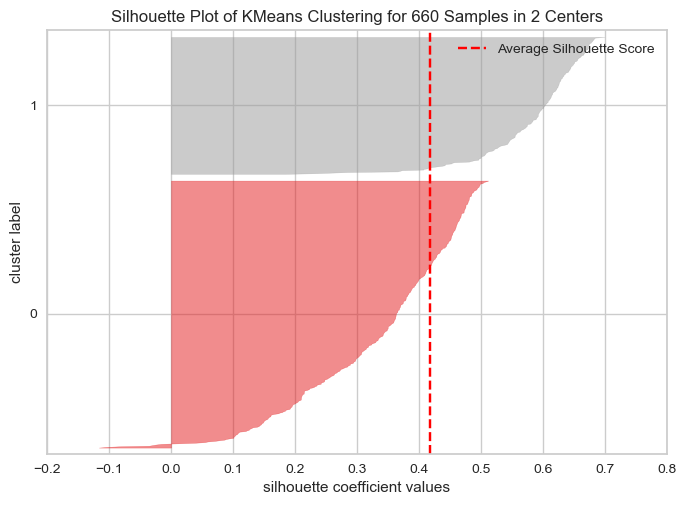

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [34]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(dataScaled)
visualizer.show()

* **For Kmeans =2 , we can see from the Visualizer that the clusters have different width and also the silhouette score is also very high.But there seems to be some values having negative silhouette coefficent value in cluster 0. This means Kmeans =2 is not the right pick for the customer segmentation**


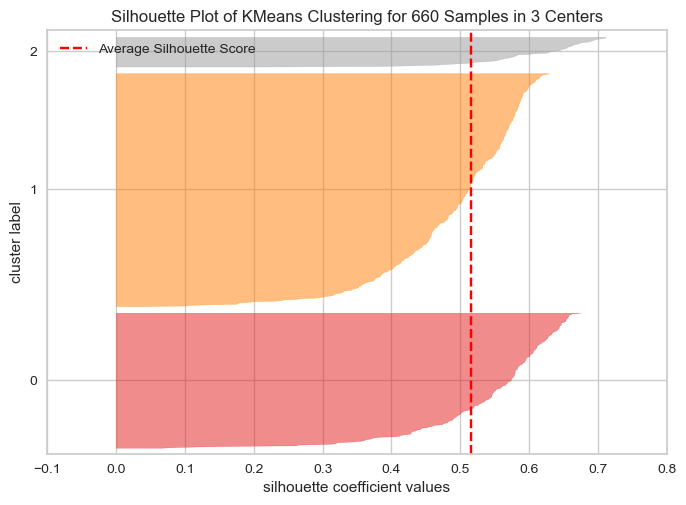

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [35]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(dataScaled)
visualizer.show()

* **For Kmeans=3, we can see that the various clusters have different widths. Also, all the cluster cross the average silhouette value. There are no negative silhouette coeffiecient values and finally there was an elbow seen when looked at the elbow method.This means, Kmeans=3 can be good for our clustering**

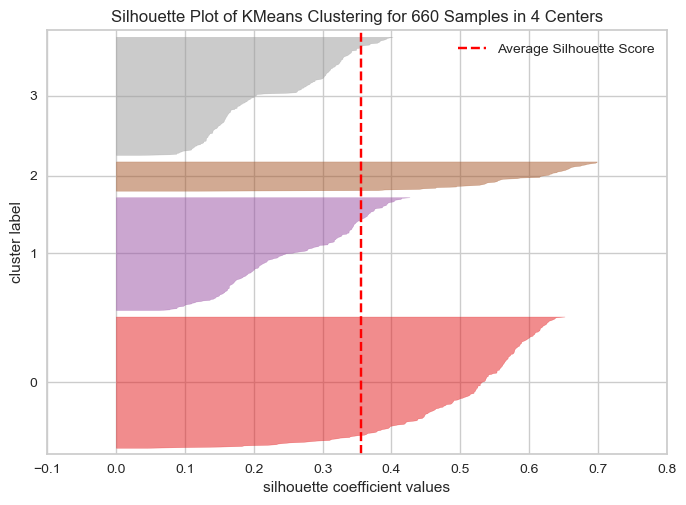

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [36]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(dataScaled)
visualizer.show()

* **For Kmeans=4, the clusters have different widths and they are also crossing the average silhouette score. But the Average silhouette score is low as compared to the kmeans with clusters 3. 

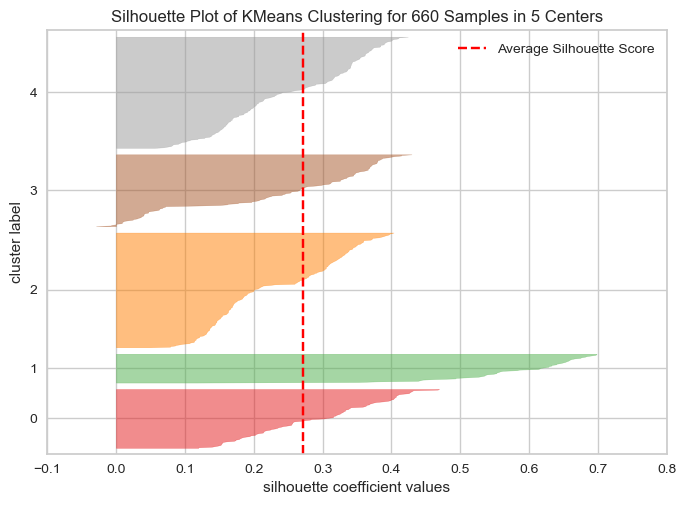

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [37]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(dataScaled)
visualizer.show()

* **Just like Kmeans = 4 , Kmeans= 5 also has clusters with different widths and they also cross the avergae silhouette score.But cluster 3 has negative coefficient values so this will not be a good selection for our kmeans**

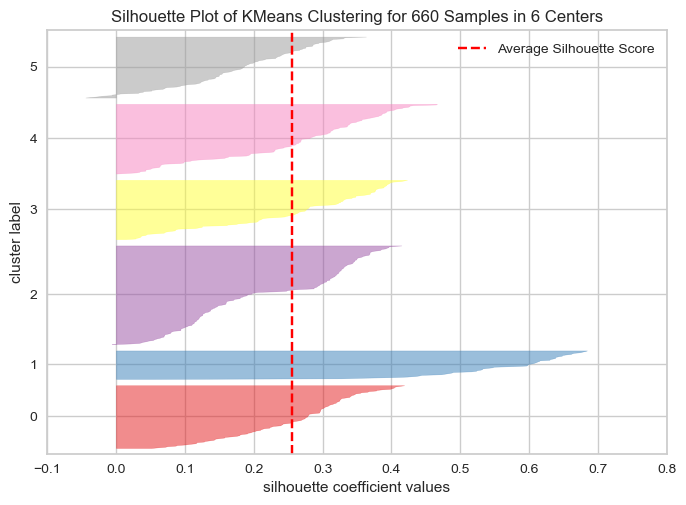

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [38]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(dataScaled)
visualizer.show()

* **For kmeans= 6, we can see that there are negative silhouette coefficient values in the plot. So this will not be a good pick for our Kmeans**

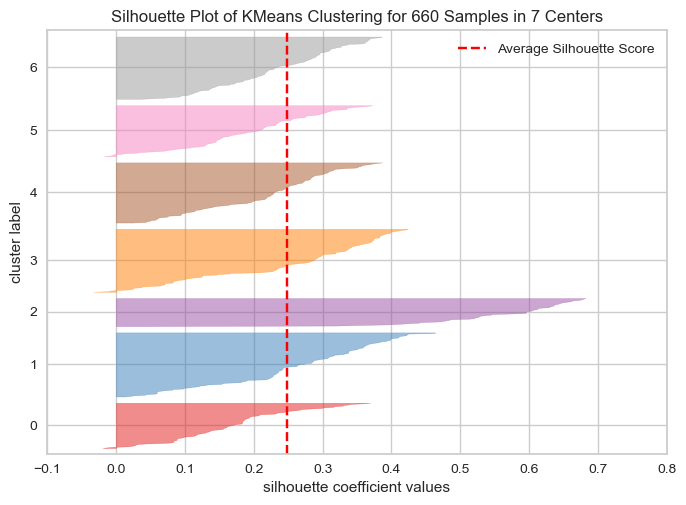

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 660 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [39]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(dataScaled)
visualizer.show()

* **For Kmeans=7, we can also see that we have some clusters having negative silhouette coefficient values, so therefore this will not be a good pick for our clustering**

### Applting Kmeans = 3

In [40]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(dataScaled)

KMeans(n_clusters=3, random_state=0)

In [41]:
# adding kmeans cluster labels to the original dataframe
data["K_means_segments"] = kmeans.labels_

In [42]:
data.head(20)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
0,1,87073,100000,2,1,1,0,0
1,2,38414,50000,3,0,10,9,1
2,3,17341,50000,7,1,3,4,0
3,4,40496,30000,5,1,1,4,0
4,5,47437,100000,6,0,12,3,2
5,6,58634,20000,3,0,1,8,1
6,7,48370,100000,5,0,11,2,2
7,8,37376,15000,3,0,1,1,1
8,9,82490,5000,2,0,2,2,1
9,10,44770,3000,4,0,1,7,1


In [43]:
cluster_profile = data.groupby("K_means_segments").mean()

In [44]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,,,
0,417.528497,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000
1,117.857143,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536
2,611.280000,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000


<AxesSubplot:xlabel='K_means_segments'>

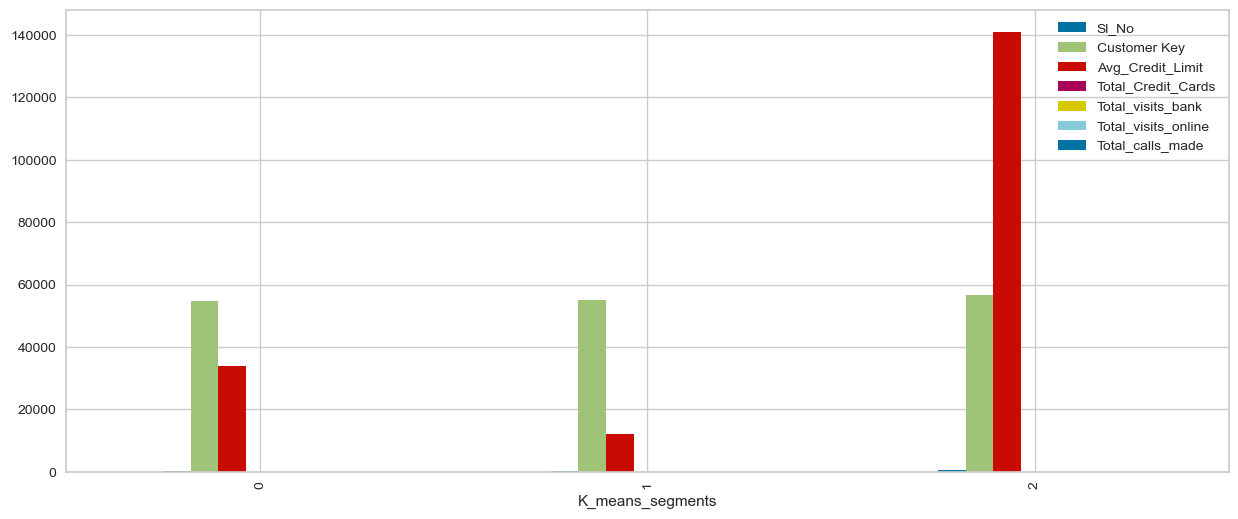

In [45]:
data.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

<AxesSubplot:xlabel='K_means_segments'>

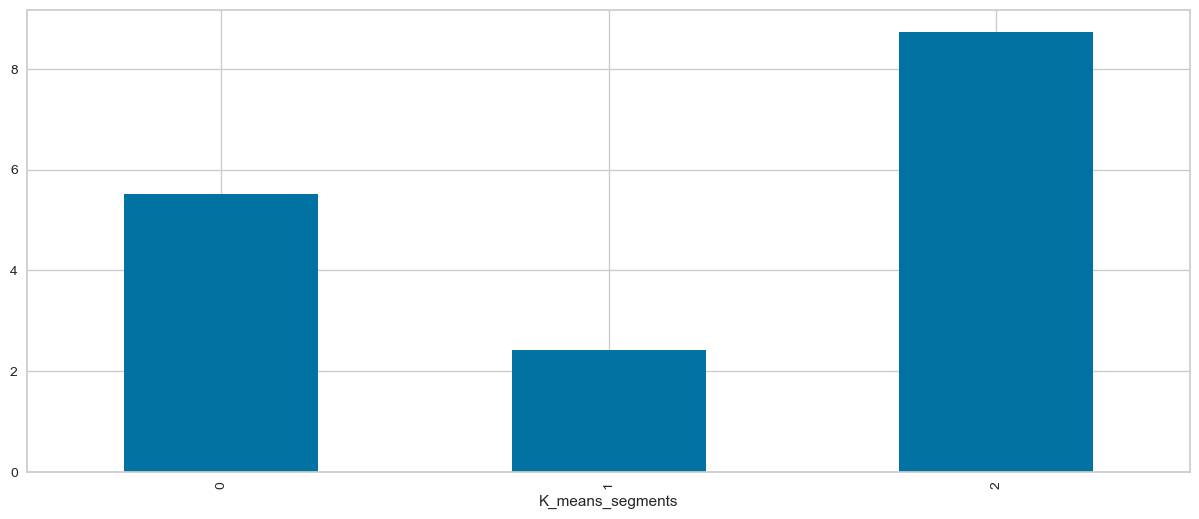

In [46]:
data.groupby(['K_means_segments'])['Total_Credit_Cards'].mean().plot.bar(figsize=(15,6))

<AxesSubplot:xlabel='K_means_segments'>

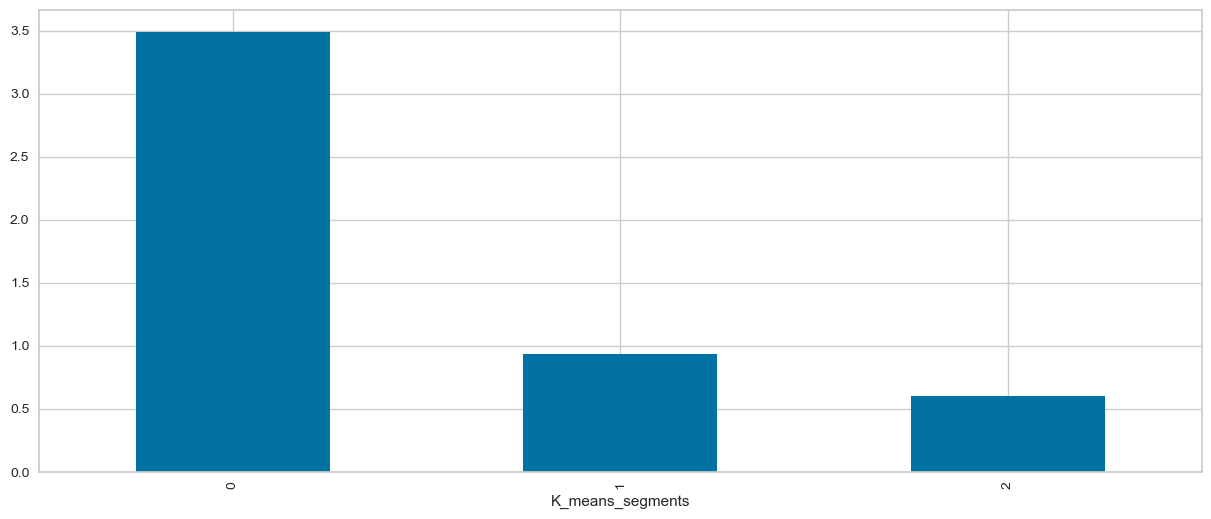

In [47]:
data.groupby(['K_means_segments'])['Total_visits_bank'].mean().plot.bar(figsize=(15,6))

<AxesSubplot:xlabel='K_means_segments'>

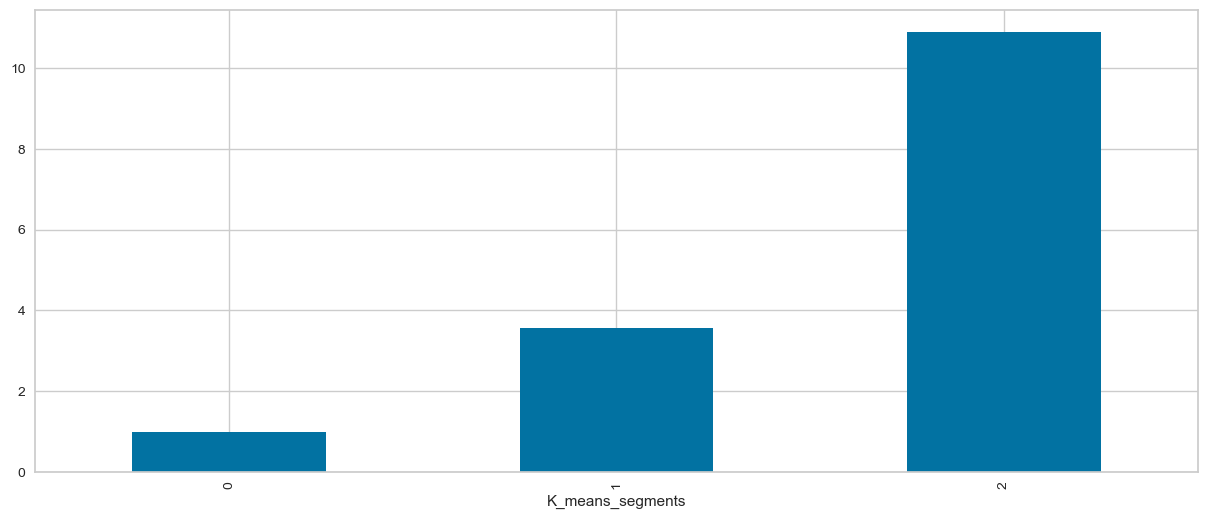

In [48]:
data.groupby(['K_means_segments'])['Total_visits_online'].mean().plot.bar(figsize=(15,6))

<AxesSubplot:xlabel='K_means_segments'>

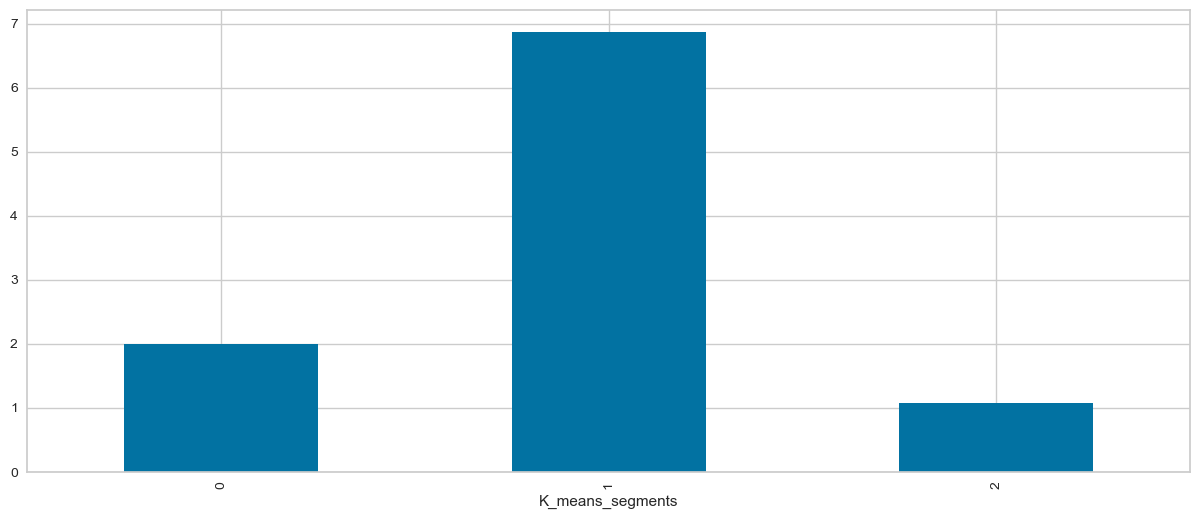

In [49]:
data.groupby(['K_means_segments'])['Total_calls_made'].mean().plot.bar(figsize=(15,6))

### Insights from Kmeans Customer Segmentation

#### Cluster 0

* For Cluster 0, they have a low Average Credit Limit but its not as low as customers in Cluster 1.
* Customers belonging to cluster 0 have the highest rate when it comes to Visiting of banks. They rather like to walk into the banks than do business online.
* They also have a lot of credit cards but not as high as those in Cluster 2

#### Cluster 1

* Customers in Cluster 1 have a very low Average Credit Limit.
* Cluster 1 Customers also have very low number of credit cards.
* Customers in this Cluster make a lot of calls to the bank

#### Cluster 2

* Customers in this Cluster have a very high Average Credit Limit.
* Also, Customers in this cluster tend to have a lot of Total Credit Cards.
* These group of Customers also seem to use the online platforms or visit the banks online platform more than the rest of the clusters.

### Hierarchical Clustering

In [50]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(dataScaled, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(dataScaled))

c

0.8977080867389372

In [51]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(dataScaled, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(dataScaled))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801747.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042134.
Cophenetic co

In [52]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


* The Cophenetic correlation is maximum with Euclidean distance and average linkage.
* Lets analyse the dendrograms and determine how many clusters to use

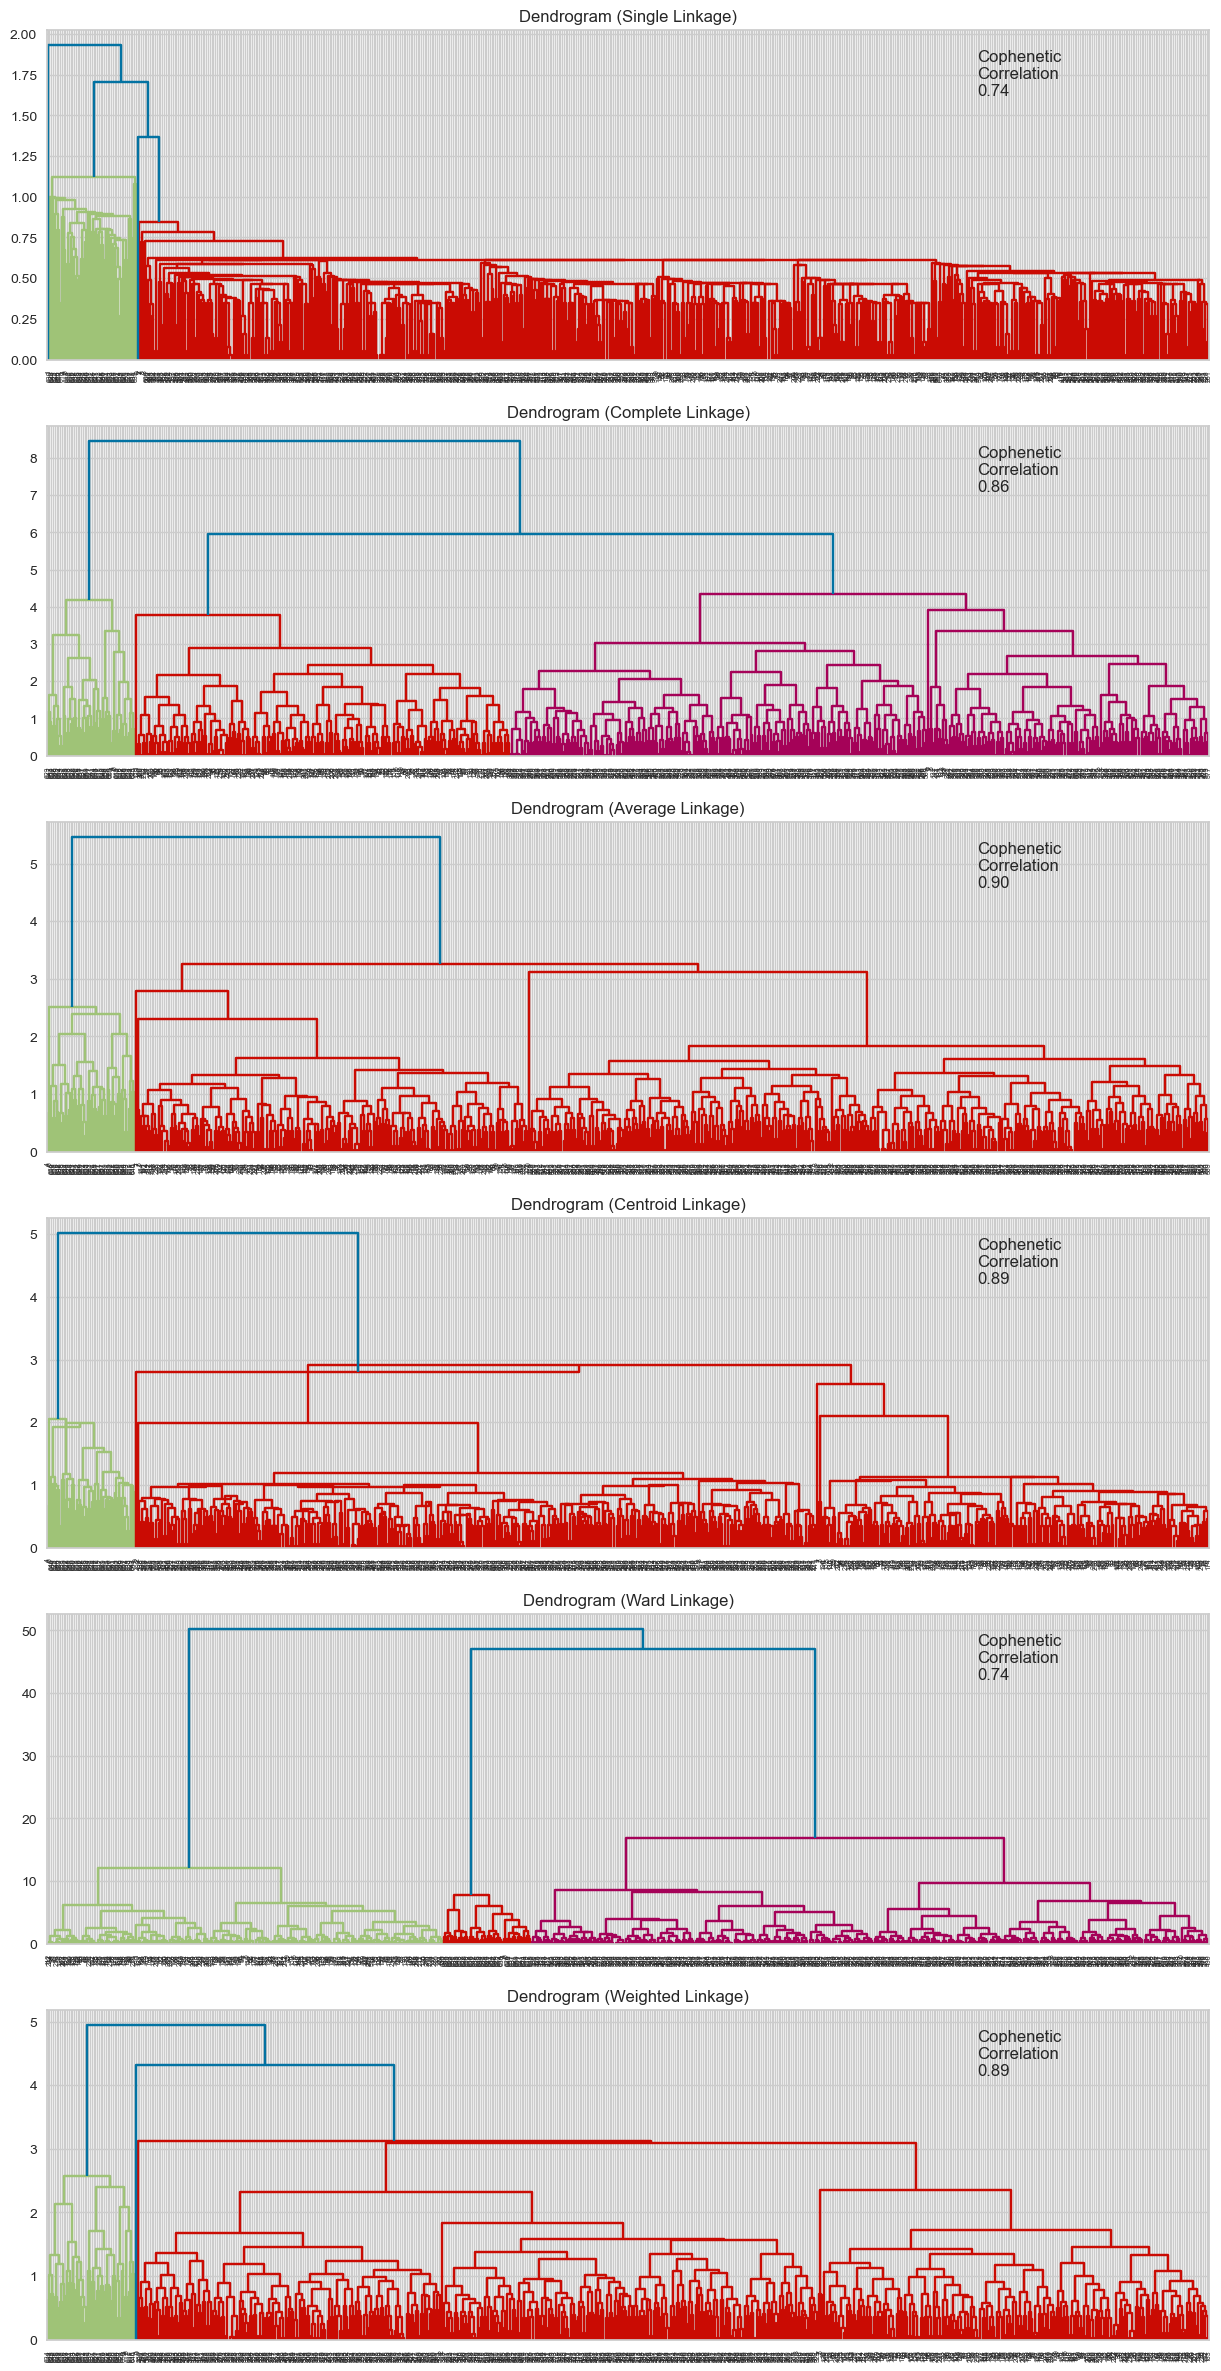

In [53]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(dataScaled, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(dataScaled))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

* Dendrograms for ward complete linkage is giving distinct clusters same as complete linkage. But complete linkage has a high Cophenetic Correlation

* Let's see the dendrogram for Euclidean,Chebyshev,Cityblock distances with average and weighted linkage methods (as they gave high cophenetic correlation values).

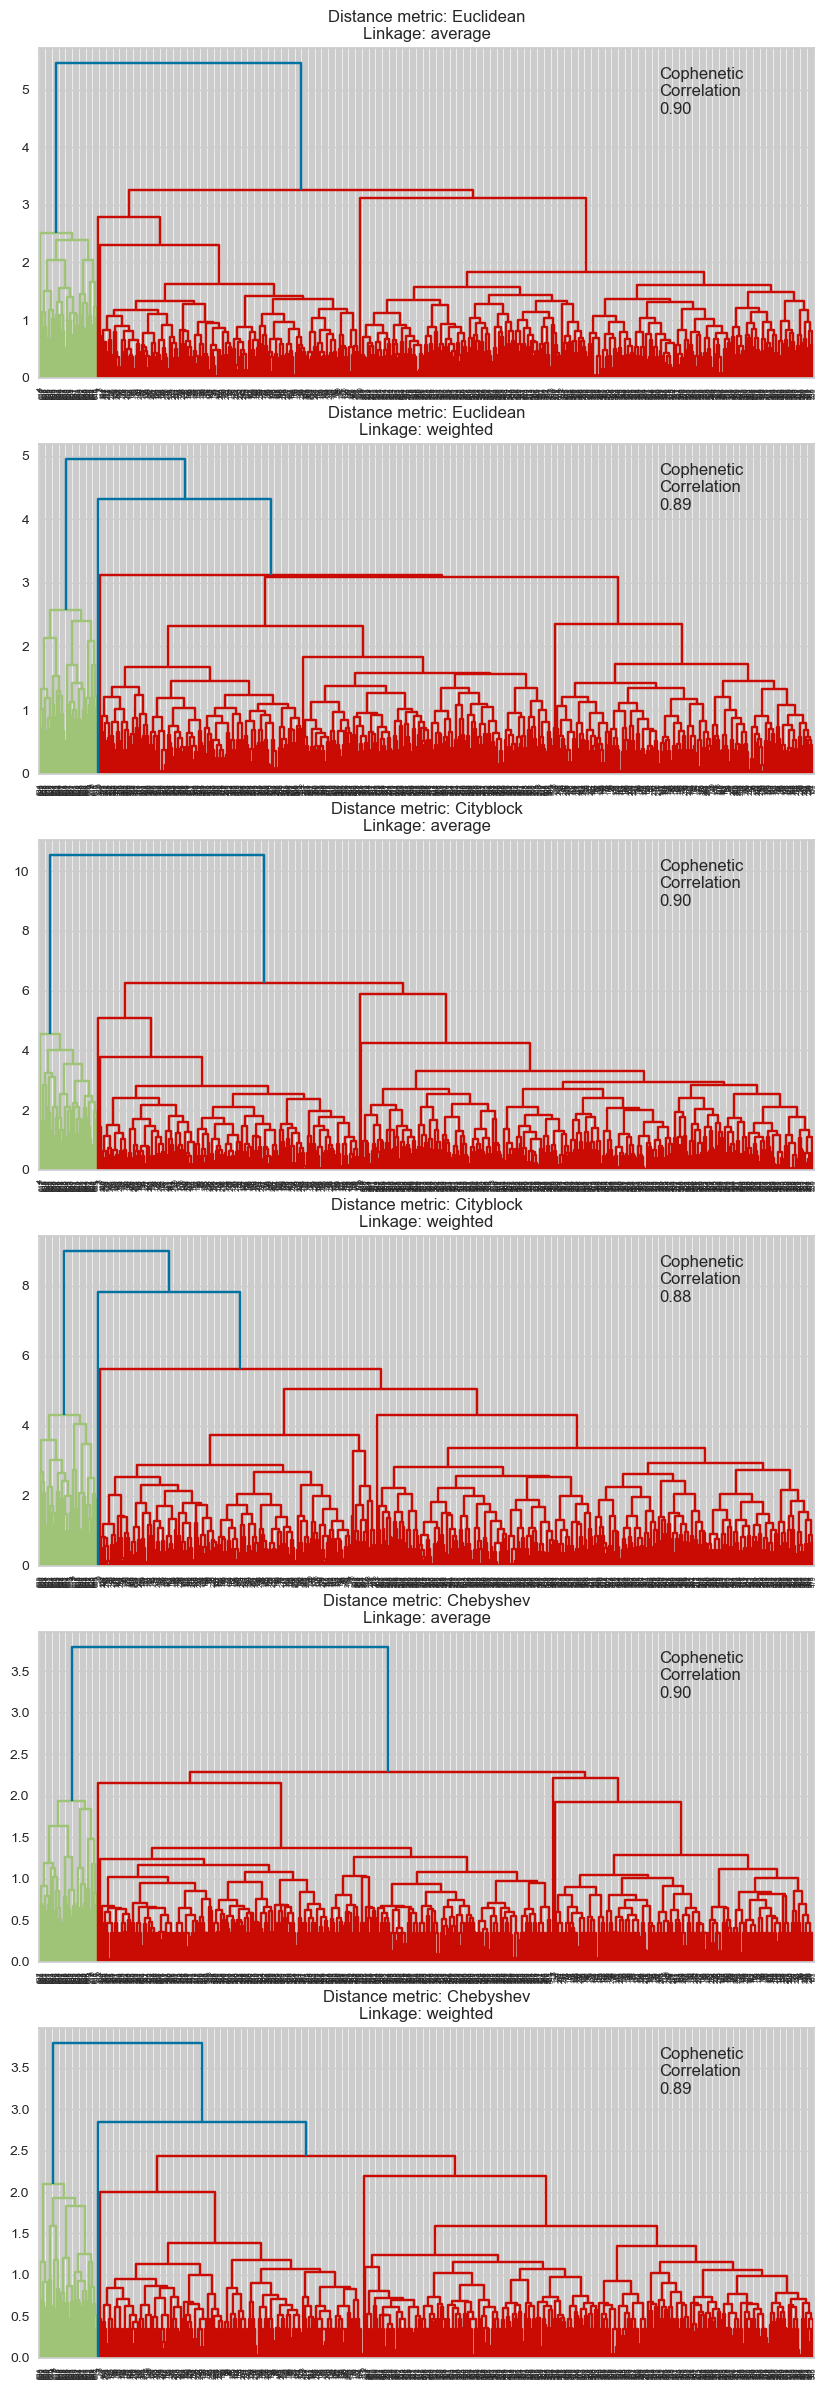

In [54]:
# list of distance metrics
distance_metrics = ["Euclidean", "cityblock",'chebyshev']

# list of linkage methods
linkage_methods = ["average", "weighted"]

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(dataScaled, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(dataScaled))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

* From the dendrograms, it is obvious that we 3 clusters is the best option since all dendrograms are giving us three distinct clusters.
* We will pick the one with Euclidean distance and average linkage.

#### Let's Create 3 clusters

In [55]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(dataScaled)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [56]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = HCmodel.labels_

In [57]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
0,1,87073,100000,2,1,1,0,0
1,2,38414,50000,3,0,10,9,2
2,3,17341,50000,7,1,3,4,0
3,4,40496,30000,5,1,1,4,0
4,5,47437,100000,6,0,12,3,1


In [58]:
cluster_profile1 = df.groupby("K_means_segments").mean()

In [59]:
# let's display cluster profiles
cluster_profile1.style.highlight_max(color="lightgreen", axis=0)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,,,
0,417.260982,54925.966408,33713.178295,5.511628,3.485788,0.984496,2.005168
1,611.280000,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000
2,116.977578,55163.973094,12197.309417,2.403587,0.928251,3.560538,6.883408


<AxesSubplot:xlabel='K_means_segments'>

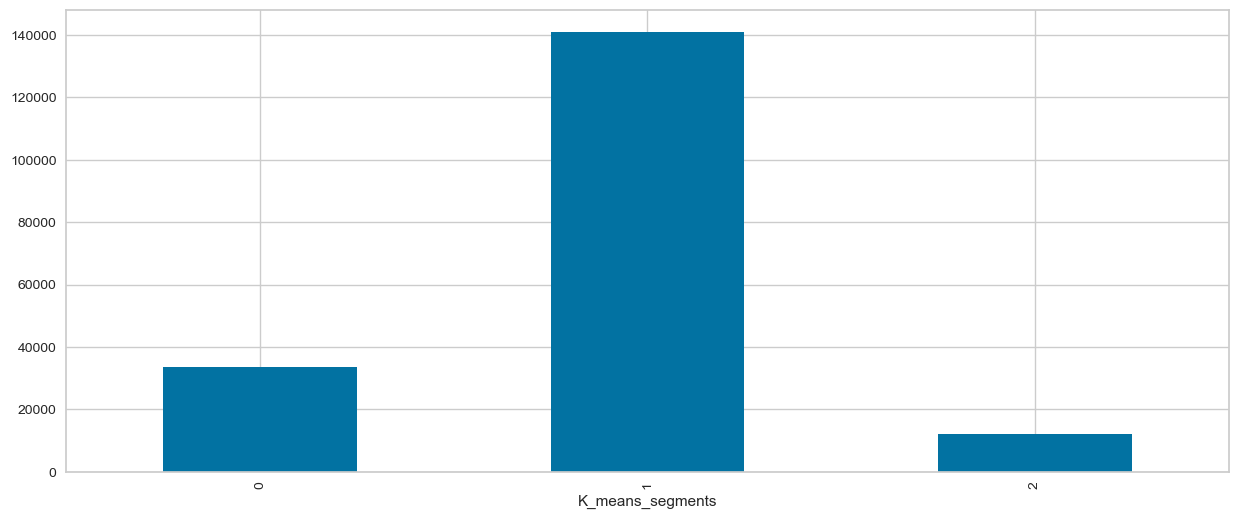

In [60]:
df.groupby(['K_means_segments'])['Avg_Credit_Limit'].mean().plot.bar(figsize=(15,6))

<AxesSubplot:xlabel='K_means_segments'>

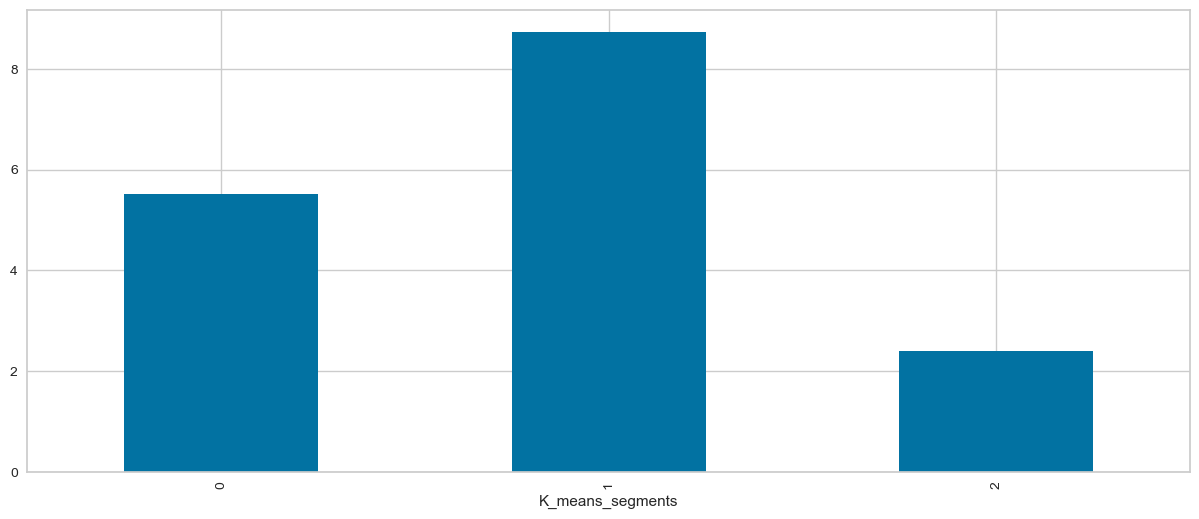

In [61]:
df.groupby(['K_means_segments'])['Total_Credit_Cards'].mean().plot.bar(figsize=(15,6))

<AxesSubplot:xlabel='K_means_segments'>

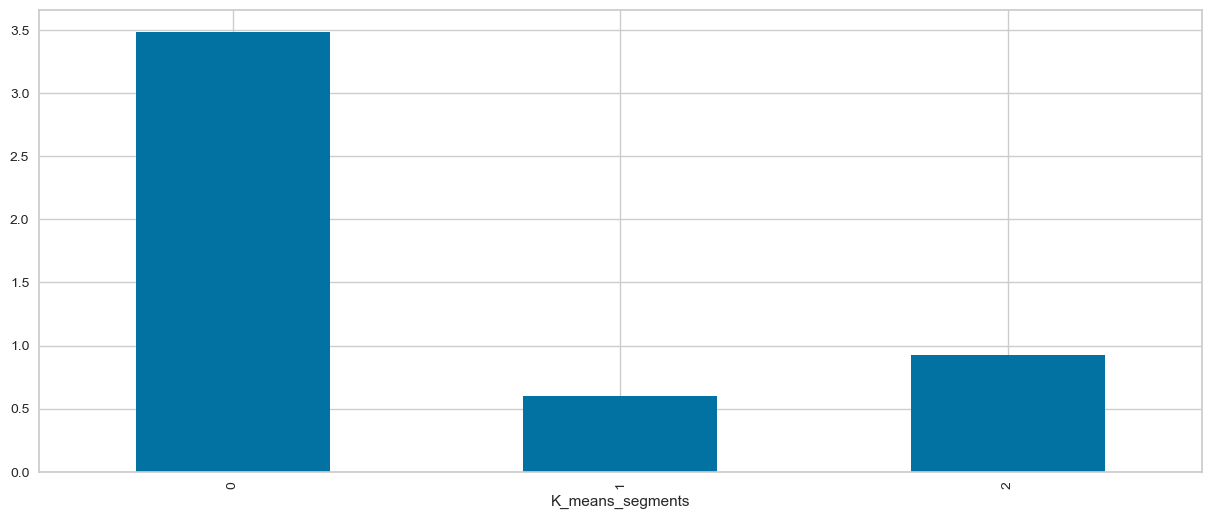

In [63]:
df.groupby(['K_means_segments'])['Total_visits_bank'].mean().plot.bar(figsize=(15,6))

<AxesSubplot:xlabel='K_means_segments'>

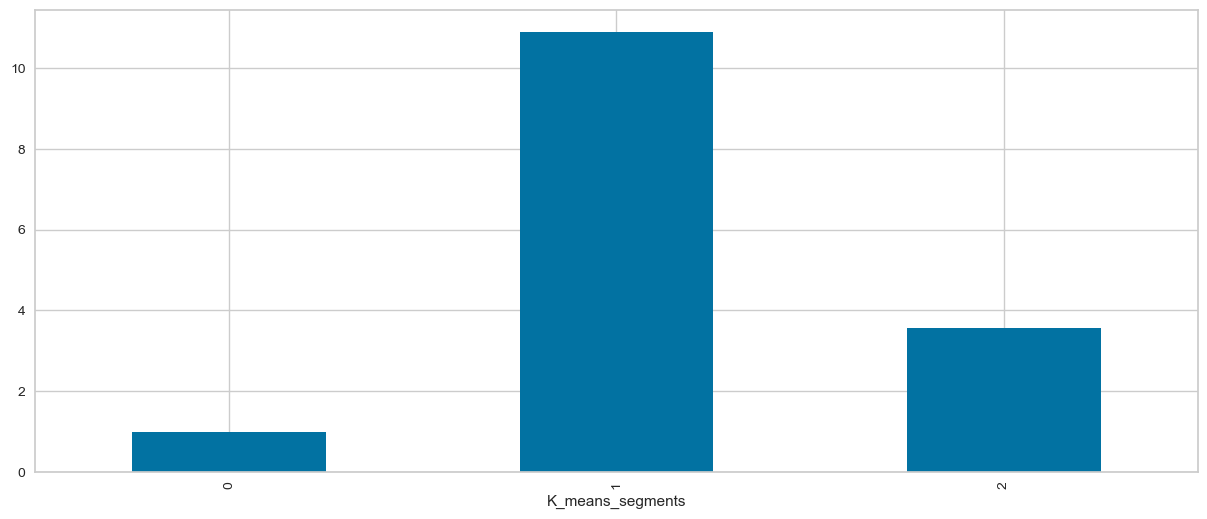

In [64]:
df.groupby(['K_means_segments'])['Total_visits_online'].mean().plot.bar(figsize=(15,6))

<AxesSubplot:xlabel='K_means_segments'>

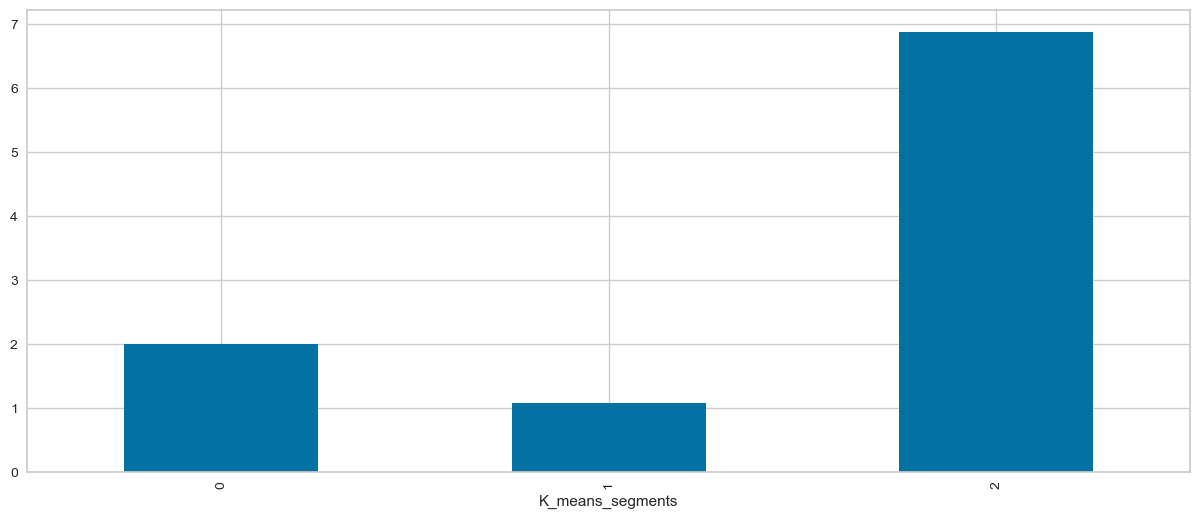

In [65]:
df.groupby(['K_means_segments'])['Total_calls_made'].mean().plot.bar(figsize=(15,6))

### Insights from Hierarchical Customer Segmentation

#### Cluster 0

* For Cluster 0, they have a low Average Credit Limit but its not as low as customers in Cluster 2.
* Customers belonging to cluster 0 have the highest rate when it comes to Visiting of banks. They rather like to walk into the banks than do business online.
* They also have a lot of credit cards but not as high as those in Cluster 1

#### Cluster 1

* Customers in Cluster 1 have a very high Average Credit Limit.
* Cluster 1 Customers also have very high number of credit cards.
* Customers in this Cluster make a lot of online visits to the bank

#### Cluster 2

* Customers in Cluster 2 have a very low Average Credit Limit.
* Cluster 2 Customers also have very low number of credit cards.
* Customers in this Cluster make a lot of calls to the bank

### KMEANS VS HIERARCHICAL CLUSTERING

* Both Clustersing methods showed the same insights with the various clusters.
* For Kmeans and Hierarchical clustering, the cluster 0 has the same attributes for both Kmeans and Hierarchical. But the other clusters are not the same;that is, the attributes for cluster 2 in the Kmeans is not the same for cluster 2 in Hierarchical.
* Cluster 2 in Kmean are customers who are high value customers but in Hierarchical, the customers in cluster 2 are the low value ones.

### ACTIONABLE INSIGHTS AND RECOMMENDATIONS

* The Marketing team should use this segmentation metric to do some bit of target marketing. This can help them cut cost in regards to marketing and have good Return on Investments values(ROI)
* Since the segmentation gives us the attributes of these customers, the sales team should know how to do more of targeted sales rather than selling any kind of product to just any customer.
* The Strategy and management team should be able to use this clustering method to see how customers change to become either high value customers or low value ones and use those observations to draw up sales plans and others,
* Also, the data engineering team should enable more features for this data like how frequently a customer withdraws and deposits and the total monetary value. These features can help with a better segmentation.